# Example: modeling tropical storm counts

The number of tropical storms is an example of a variable that is not expected to be normally distributed. Counts cannot be negative, are often skewed and tend to follow a Poisson distribution.

This example follows the general approach of [Villarini et al. (2010)](https://journals.ametsoc.org/view/journals/mwre/138/7/2010mwr3315.1.xml) in using Poisson regression to model the number of tropical storms based on climate indices.

The goal of Poisson regression is to model a rate of occurrence, $\Lambda_i$, where the rate changes for each observation $i$. This model can be expressed as a generalized linear model (GLM) with a *logarithmic link function*.

$$\log(\Lambda_i) = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_n x_{ki}$$

which is the same as

$$\Lambda_i = \exp(\beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_n x_{ki})$$

This is a model for the rate of occurrence $\Lambda_i$ as a function of $k$ predictor variables. In this example, the rate of occurrence $\Lambda_i$ is the number of storm counts per year and each climate index is a predictor variable. 

* The logarithmic link function is useful because $\log(\Lambda_i)$ can be positive or negative, but $\Lambda_i$ must be positive

* If the data being modeled is a standard Poisson random variable, the model simplifies to $\Lambda_i = \exp({\beta_0})$

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

We use a special function to load the climate indices from NOAA.

In [2]:
def read_psl_file(psl_file):
    '''
    Read a data file in in NOAA Physical Sciences Laboratory (PSL) format
    
    Input: String containing the path to a PSL data file
    Returns: Pandas dataframe with monthly data in columns and the year as the index
    
    For a description of the PSL format see: https://psl.noaa.gov/gcos_wgsp/Timeseries/standard/
    '''
    
    f = open(psl_file, "r")
    all_lines = f.readlines()
    start_year = all_lines[0].split()[0]
    end_year = all_lines[0].split()[1]

    for i in range(1,len(all_lines)):
        stri = all_lines[i].find(end_year)
        if stri>=0:
            end_index = i

    missing_val = float(all_lines[end_index+1])
    nrows = int(end_year)-int(start_year)+1
    df = pd.read_csv(psl_file,skiprows=1,nrows=nrows,sep='\s+',header=None,na_values=missing_val)
    df = df.rename(columns={0:'year'})
    df = df.set_index('year',drop=True)
    
    return df

In [5]:
dfsoi = read_psl_file('data/tropical-storms/soi.data')
dftna = read_psl_file('data/tropical-storms/tna.data')
dfnao = read_psl_file('data/tropical-storms/nao.data')

Load the tropical storm data.

In [6]:
dftrop = pd.read_csv('data/tropical-storms/tropical.txt',sep='\t')
dftrop = dftrop.set_index('Year',drop=False)

Tropical storms do not happen in winter, so we average the climate indices during the relevant months.

In [7]:
dftrop['SOI'] = dfsoi.loc[:,5:6].mean(axis=1)
dftrop['TNA'] = dftna.loc[:,5:6].mean(axis=1)
dftrop['NAO'] = dfnao.loc[:,5:6].mean(axis=1)

##### Exercises
* How would you find the NAO averaged over July-September?
* How would you find the NAO for years 2010-2020, averaged over July-September?
* How would you use `dfnao.iloc` to achieve the same result?

Drop all rows with any NaN values.

In [8]:
df = dftrop.dropna()

In [9]:
df

,Year,NamedStorms,NamedStormDays,Hurricanes,HurricaneDays,MajorHurricanes,MajorHurricaneDays,AccumulatedCycloneEnergy,SOI,TNA,NAO
Year,,,,,,,,,,,
1951,1951,12,67.00,8,34.25,3,4.50,126.3,-0.40,0.155,-0.925
1952,1952,11,45.75,5,15.50,2,2.50,69.1,1.20,0.205,-0.545
1953,1953,14,61.75,7,19.00,3,5.00,98.5,-1.30,0.120,0.425
1954,1954,16,57.00,7,26.00,3,7.00,104.4,0.50,0.045,0.015
1955,1955,13,85.50,9,43.00,4,8.50,164.7,1.95,-0.065,-0.530
...,...,...,...,...,...,...,...,...,...,...,...
2016,2016,15,81.00,7,27.75,4,10.25,141.3,0.90,0.385,-0.400
2017,2017,17,93.00,10,51.75,6,19.25,224.9,-0.15,0.590,-0.685
2018,2018,15,87.25,8,26.75,2,5.00,129.0,0.20,-0.440,1.715


Histogram of the named storm counts.

<AxesSubplot:>

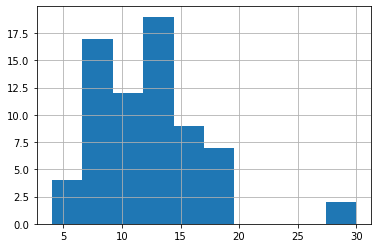

In [10]:
plt.figure()
df['NamedStorms'].hist()

Poisson regression model, including a linear temporal trend.

In [11]:
result = smf.glm(formula='NamedStorms ~ Year + NAO + SOI + TNA',
                 data=df,
                 family=sm.families.Poisson()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            NamedStorms   No. Observations:                   70
Model:                            GLM   Df Residuals:                       65
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -186.77
Date:                Sun, 14 Mar 2021   Deviance:                       73.614
Time:                        21:48:33   Pearson chi2:                     73.3
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.9786      3.621     -2.480      0.013     -16.076      -1.881
Year           0.0057      0.002      3.154      0.002       0.002       0.009
NAO           -0.0267      0.048     -0.558      0.577      -0.120       0.067
SOI            0.0620      0.037      1.654      0.098      -0.011       0.135
TNA            0.3563      0.096      3.729      0.000       0.169       0.544
==============================================================================
"""

In [12]:
beta = result.params

In [13]:
beta

Intercept   -8.978558
Year         0.005747
NAO         -0.026677
SOI          0.061967
TNA          0.356328
dtype: float64

#### Exercises
* Create a Python variable `y` that contains the observed count data.
* Create a Python variable `yhat` that contains the modeled count data (use the parameters in `beta`).
* Make plots comparing the observed and modeled counts.